In [1]:
import os

import matplotlib.pyplot as plt
import mne
import numpy as np
import pandas as pd
import pingouin as pg
import seaborn as sns
import xarray as xr
from plotting import plot_eeg_topomaps
from scipy.stats import zscore
from tqdm import tqdm
from utils import run_in_parallel

plt.style.use("papers")

DATA_FOLDER = "../../data/test_data_LEMON/"
RESULTS_FOLDER = "/Users/nikola/work-brain/eeg_microstate_and_latent_space/results/20220707_VARprocess_EC_50subjects_60.0s_segment_3600.0s_VARlength/"

# VAR orders

In [2]:
orders_raw = pd.read_csv(os.path.join(RESULTS_FOLDER, "VAR_orders_aic.csv"))
orders = []
for col in orders_raw.filter(like="sub"):
    orders.append(orders_raw[["order", col]].dropna(axis=0).set_index("order"))
orders = pd.concat(orders, axis=1)

mins = orders.idxmin()
display(mins)
display(mins.median(), mins.mean())

sub-010037_EC    10
sub-010027_EC    10
sub-010010_EC    10
sub-010029_EC    10
sub-010012_EC    10
sub-010052_EC    10
sub-010017_EC    10
sub-010046_EC     7
sub-010005_EC    10
sub-010048_EC     9
sub-010062_EC    10
sub-010069_EC    10
sub-010072_EC    10
sub-010063_EC    10
sub-010068_EC    10
sub-010070_EC    10
sub-010065_EC    10
sub-010090_EC    10
sub-010071_EC    10
sub-010081_EC    10
sub-010104_EC    10
sub-010126_EC    10
sub-010163_EC    10
sub-010166_EC    10
sub-010134_EC     9
sub-010148_EC    10
sub-010146_EC    10
sub-010137_EC    10
sub-010152_EC    10
sub-010170_EC    10
sub-010196_EC    10
sub-010197_EC    10
sub-010220_EC    10
sub-010202_EC     7
sub-010218_EC    10
sub-010230_EC    10
sub-010240_EC    10
sub-010238_EC    10
sub-010247_EC    10
sub-010255_EC    10
sub-010268_EC    10
sub-010295_EC    10
sub-010296_EC    10
sub-010298_EC    10
sub-010315_EC    10
sub-010309_EC    10
sub-010310_EC    10
sub-010316_EC    10
sub-010311_EC    10
sub-010318_EC    10


10.0

9.84

<AxesSubplot:xlabel='order', ylabel='AIC'>

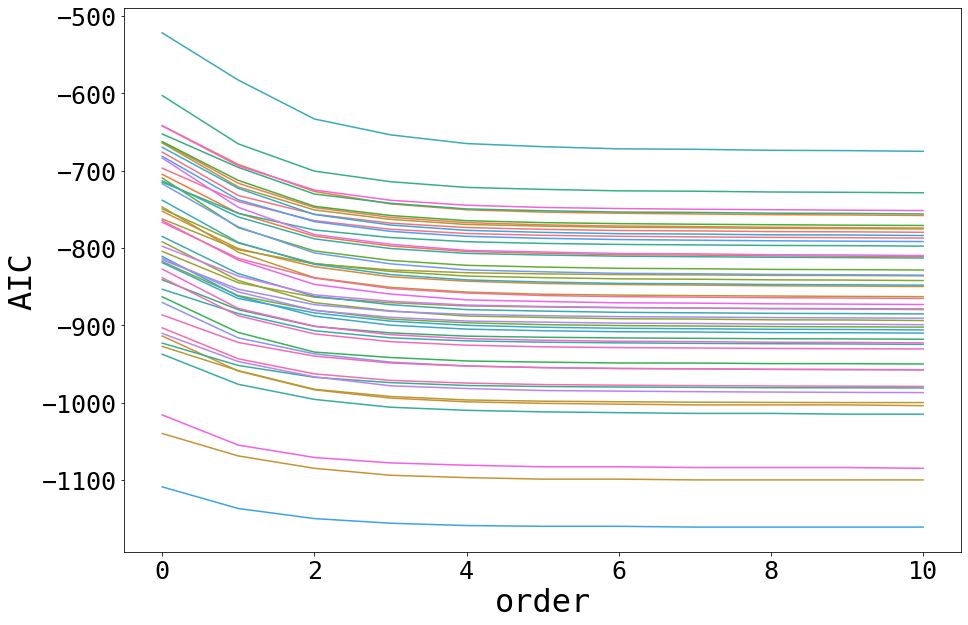

In [3]:
plt.figure(figsize=(15, 10))
sns.lineplot(
    data=orders.reset_index().melt(
        id_vars="order", value_name="AIC", var_name="subject"
    ),
    x="order",
    y="AIC",
    hue="subject",
    legend=False,
)

# Topomaps

In [4]:
topomaps = xr.open_dataarray(os.path.join(RESULTS_FOLDER, "topomaps.nc"))
topomaps = topomaps.set_index({"stack": ["subject_id", "type"]}).unstack()

/var/folders/8l/kg7qz2vn3jn9_bzjm1p_pgq40000gn/T/ipykernel_28212/1854914166.py:3: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  os.path.join(DATA_FOLDER, f"{subj_id}_EC.set"), preload=False
/var/folders/8l/kg7qz2vn3jn9_bzjm1p_pgq40000gn/T/ipykernel_28212/1854914166.py:3: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  os.path.join(DATA_FOLDER, f"{subj_id}_EC.set"), preload=False


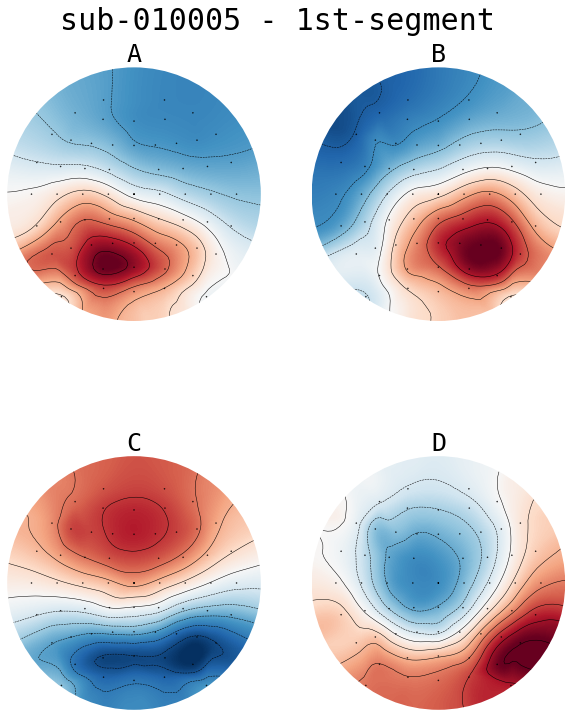

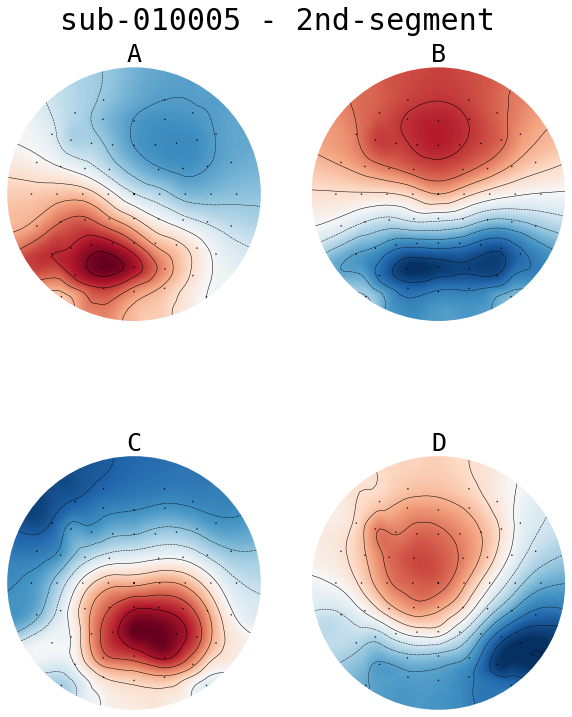

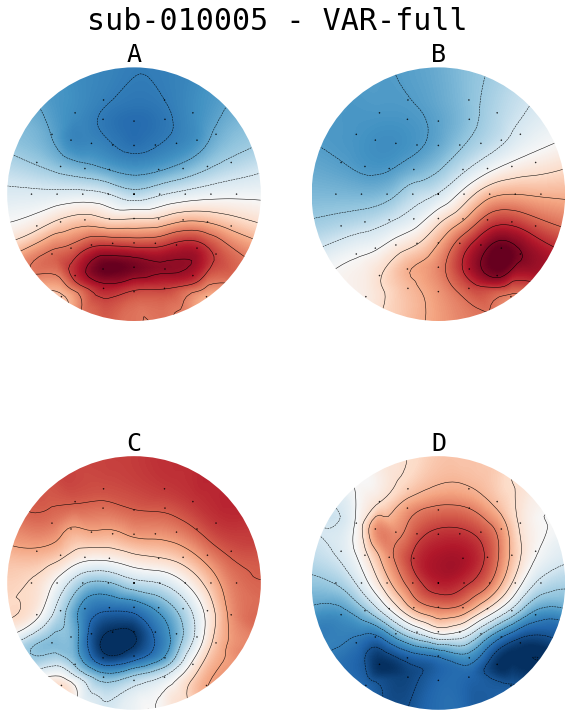

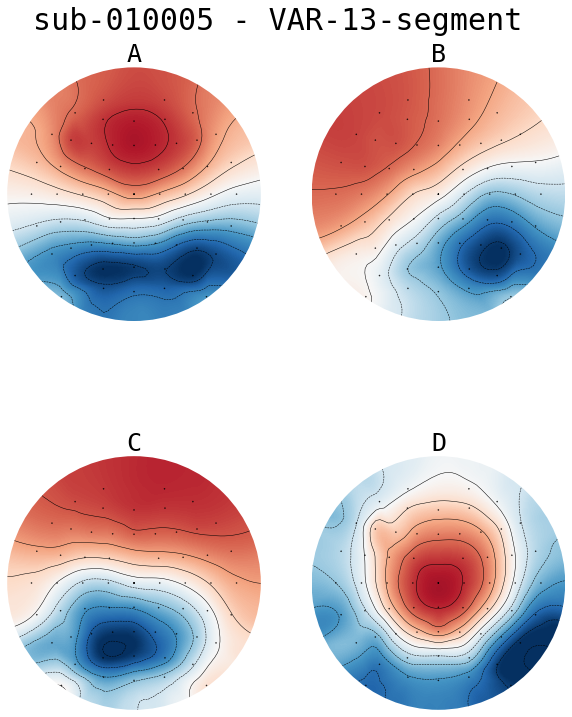

In [5]:
subj_id = "sub-010005"
subj_info = mne.io.read_raw_eeglab(
    os.path.join(DATA_FOLDER, f"{subj_id}_EC.set"), preload=False
)
PLOT_TYPES = ["1st-segment", "2nd-segment", "VAR-full", "VAR-13-segment"]

for plot_type in PLOT_TYPES:
    plot_eeg_topomaps(
        topomaps.sel({"subject_id": subj_id, "type": plot_type})
        .dropna("channels")
        .values,
        subj_info.info,
        title=subj_id + " - " + plot_type,
    )
    plt.show()

# Topomaps accordance

In [6]:
all_corrs = []
TYPES = list(topomaps["type"].values)
for typ1 in TYPES:
    for typ2 in TYPES:
        all_corrs.append(
            xr.corr(
                topomaps.sel({"type": typ1}),
                topomaps.sel({"type": typ2}),
                dim="channels",
            )
            .assign_coords({"type1": typ1, "type2": typ2})
            .expand_dims(["type1", "type2"])
        )

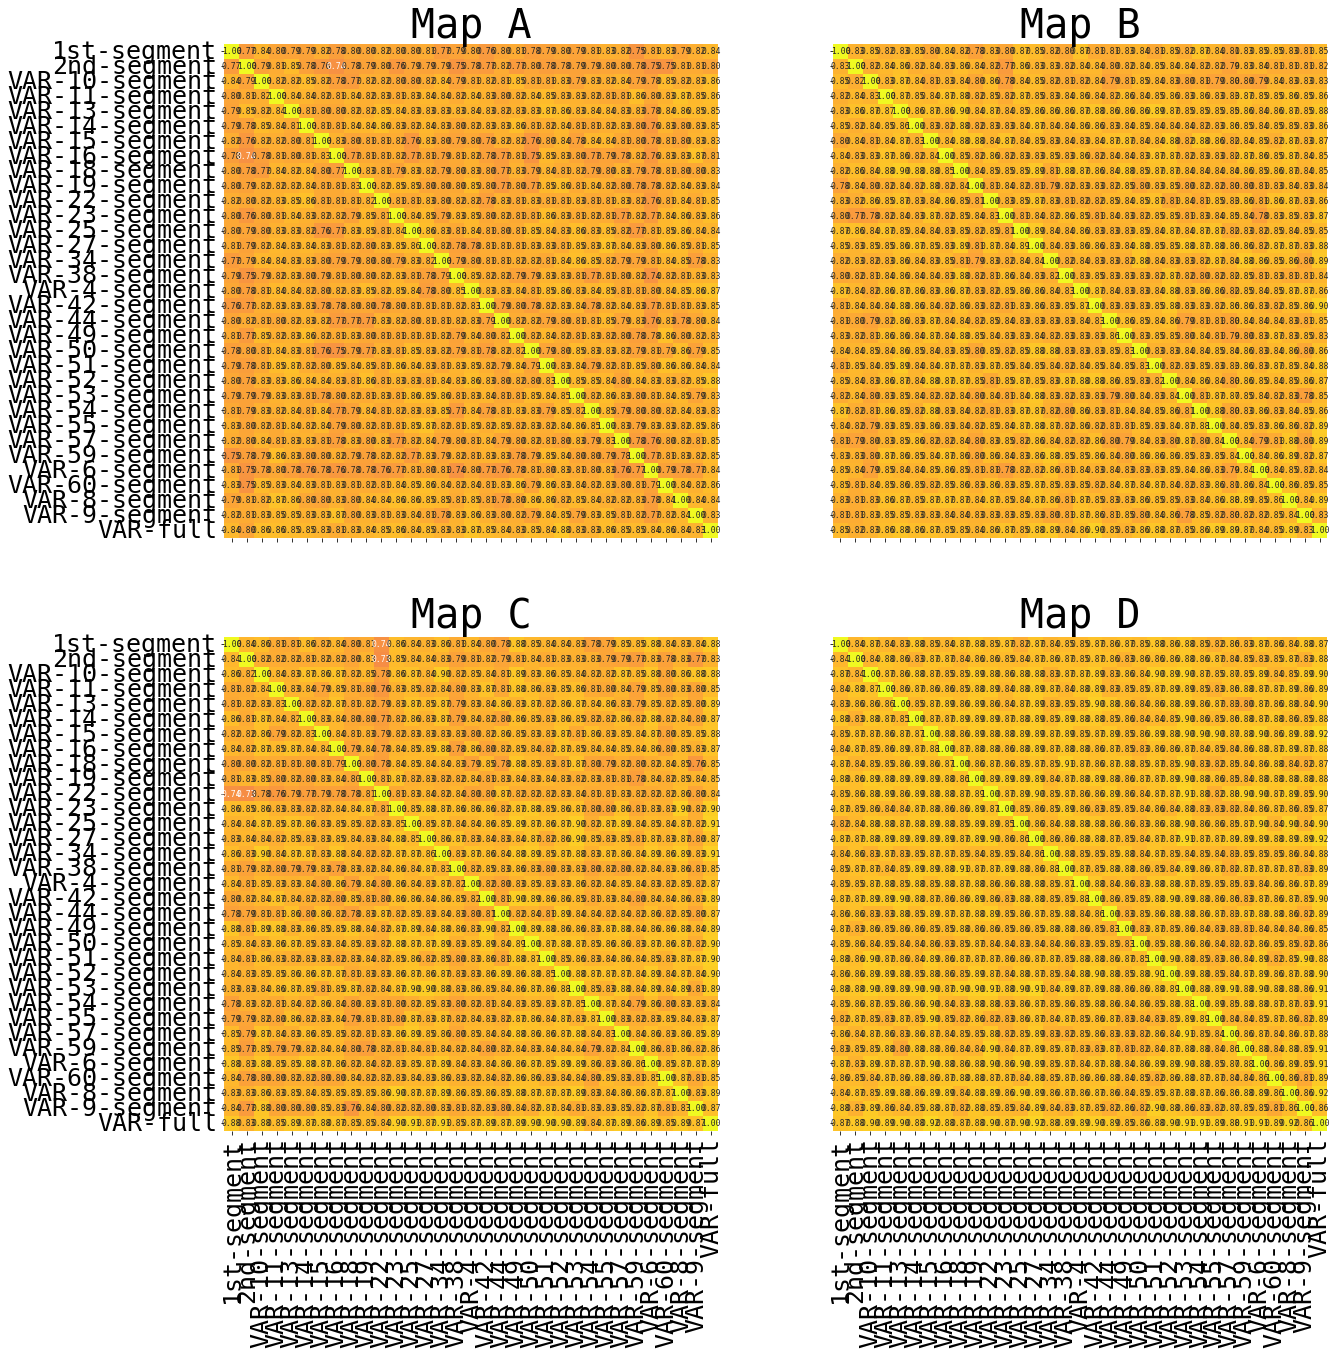

In [7]:
corrs = np.abs(xr.combine_by_coords(all_corrs))
corrs

fig, axs = plt.subplots(
    nrows=2, ncols=2, squeeze=True, figsize=(20, 20), sharey=True, sharex=True
)
axs = axs.flatten()
for i, lamap in enumerate(corrs["latent map"]):
    sns.heatmap(
        corrs.mean(dim="subject_id").sel({"latent map": lamap}),
        square=True,
        ax=axs[i],
        cbar=False,
        cmap="plasma",
        annot_kws={"size": 8},
        annot=True,
        vmin=0,
        vmax=1,
        fmt=".2f",
    )
    axs[i].set_xticks(np.arange(len(TYPES)) + 0.5, TYPES, rotation=90)
    axs[i].set_yticks(np.arange(len(TYPES)) + 0.5, TYPES, rotation=0)
    axs[i].set_title(f"Map {lamap.values}")

In [8]:
TYPES = ["1st-segment", "2nd-segment", "VAR-full"]
SUBJECTS = np.unique(topomaps.coords["subject_id"].values)


def _compute_corr(args):
    topomaps, typ1, typ2, subj1, subj2 = args
    return (
        xr.corr(
            topomaps.sel({"type": typ1, "subject_id": subj1}),
            topomaps.sel({"type": typ2, "subject_id": subj2}),
            dim="channels",
        )
        .assign_coords({"type1": typ1, "type2": typ2, "subj1": subj1, "subj2": subj2})
        .expand_dims(["type1", "type2", "subj1", "subj2"])
    )


all_corrs2 = run_in_parallel(
    _compute_corr,
    [
        (topomaps, typ1, typ2, subj1, subj2)
        for typ1 in TYPES
        for typ2 in TYPES
        for subj1 in SUBJECTS
        for subj2 in SUBJECTS
    ],
)

combined = np.abs(xr.combine_by_coords(all_corrs2))

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22500/22500 [01:45<00:00, 213.62it/s]


Text(244.17015810276683, 0.5, 'full VAR $\\to$ 2nd seg.')

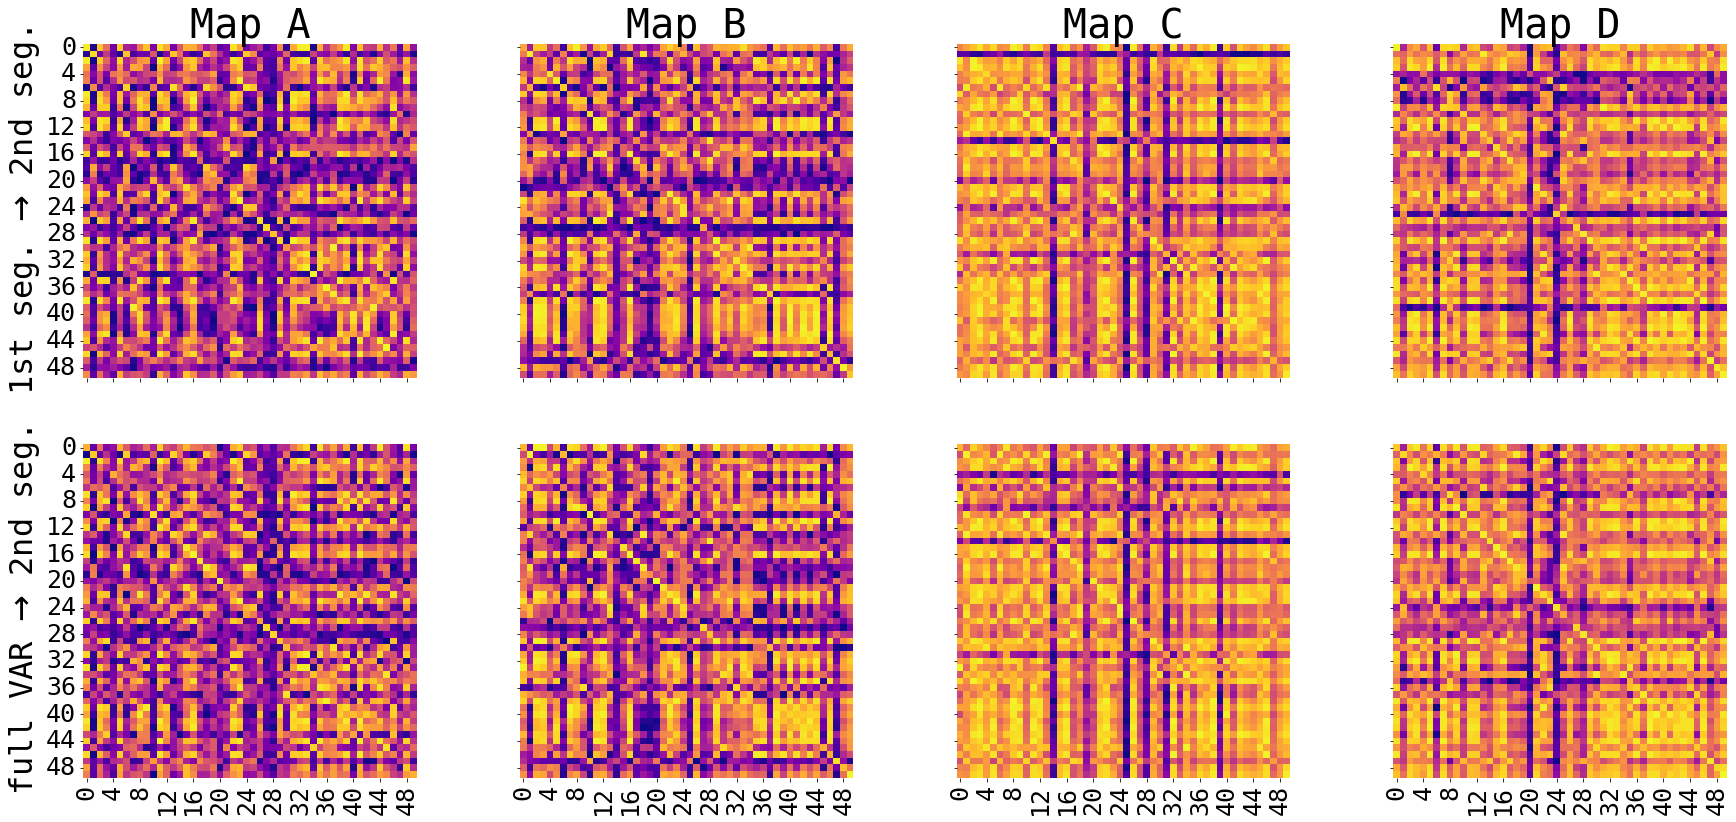

In [9]:
fig, axs = plt.subplots(
    nrows=2, ncols=4, squeeze=True, figsize=(30, 13.5), sharey=True, sharex=True
)

for i, lamap in enumerate(combined["latent map"]):
    for j, howto in enumerate(["1st-segment", "VAR-full"]):
        sns.heatmap(
            combined.sel({"type1": howto, "type2": "2nd-segment", "latent map": lamap}),
            square=True,
            ax=axs[j, i],
            cbar=False,
            cmap="plasma",
            vmin=0,
            vmax=1,
        )
    axs[0, i].set_title(f"Map {lamap.values}")
axs[0, 0].set_ylabel(r"1st seg. $\to$ 2nd seg.")
axs[1, 0].set_ylabel(r"full VAR $\to$ 2nd seg.")

Text(244.17015810276683, 0.5, 'full VAR $\\to$ 2nd seg.')

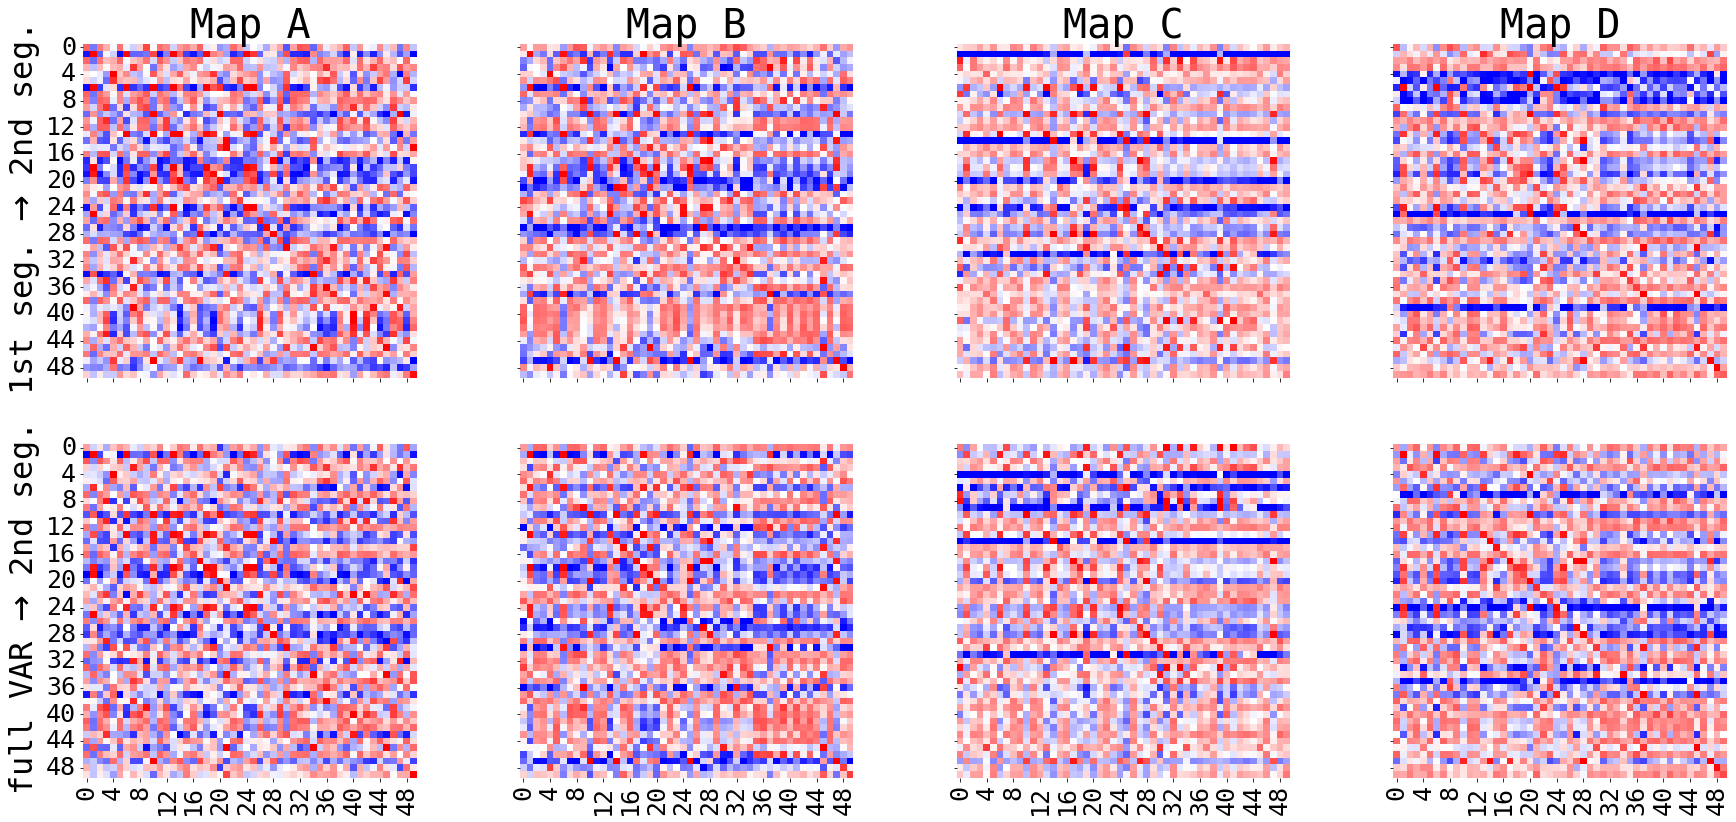

In [10]:
fig, axs = plt.subplots(
    nrows=2, ncols=4, squeeze=True, figsize=(30, 13.5), sharey=True, sharex=True
)
for i, lamap in enumerate(combined["latent map"]):
    for j, howto in enumerate(["1st-segment", "VAR-full"]):
        sns.heatmap(
            zscore(
                combined.sel(
                    {"type1": howto, "type2": "2nd-segment", "latent map": lamap}
                ).values,
                axis=0,
            ),
            square=True,
            ax=axs[j, i],
            cbar=False,
            cmap="bwr",
            vmin=-2.0,
            vmax=2.0,
        )
    axs[0, i].set_title(f"Map {lamap.values}")
axs[0, 0].set_ylabel(r"1st seg. $\to$ 2nd seg.")
axs[1, 0].set_ylabel(r"full VAR $\to$ 2nd seg.")

In [11]:
correct_classif = pd.DataFrame(
    columns=list(combined["latent map"].values), index=["1st-segment", "VAR-full"]
)

for lamap in combined["latent map"]:
    for howto in ["1st-segment", "VAR-full"]:
        correct_classif.loc[howto, str(lamap.values)] = (
            combined.sel(
                {"latent map": lamap, "type1": howto, "type2": "2nd-segment"}
            ).values.argmax(axis=0)
            == np.arange(len(SUBJECTS))
        ).sum()

display(correct_classif)

correct_classif_zs = pd.DataFrame(
    columns=list(combined["latent map"].values), index=["1st-segment", "VAR-full"]
)

for lamap in combined["latent map"]:
    for howto in ["1st-segment", "VAR-full"]:
        correct_classif_zs.loc[howto, str(lamap.values)] = (
            zscore(
                combined.sel(
                    {"latent map": lamap, "type1": howto, "type2": "2nd-segment"}
                ).values,
                axis=0,
            ).argmax(axis=0)
            == np.arange(len(SUBJECTS))
        ).sum()

display(correct_classif_zs)

,A,B,C,D
1st-segment,16,22,18,21
VAR-full,14,19,17,21


,A,B,C,D
1st-segment,16,22,18,21
VAR-full,14,19,17,21


# Static and dynamic stats

In [12]:
static_stats = pd.read_csv(
    os.path.join(RESULTS_FOLDER, "static_stats.csv"), index_col=0
)
static_stats[["subject_id", "type"]] = (
    static_stats["subject_id"].str.split("_", expand=True).drop([1], axis=1)
)
static_stats = static_stats.drop(
    ["filter", "decomposition_type", "use_gfp", "no_states"], axis=1
).sort_values(["subject_id", "type", "latent map"])
# make mean / std from VAR segments
var_means = (
    static_stats.loc[static_stats["type"].str.match("VAR-\d*-segment")]
    .groupby(["subject_id", "latent map"])
    .mean()
    .reset_index()
)
var_means["type"] = "VAR-segments-mean"

static_stats_final = pd.concat(
    [static_stats.loc[~static_stats["type"].str.match("VAR-\d*-segment")], var_means],
    axis=0,
)
static_stats_final = static_stats_final.set_index(["subject_id", "type", "latent map"])
static_stats_final

var_GFP  var_total  template_corr  \
subject_id type              latent map                                       
sub-010005 1st-segment       A           0.801166   0.740474       0.844751   
                             B           0.801166   0.740474       0.921969   
                             C           0.801166   0.740474       0.905284   
                             D           0.801166   0.740474       0.962222   
           2nd-segment       A           0.795650   0.736939       0.926329   
...                                           ...        ...            ...   
sub-010316 VAR-segments-mean D           0.822274   0.754684       0.917881   
sub-010318 VAR-segments-mean A           0.850759   0.788109       0.861090   
                             B           0.850759   0.788109       0.858120   
                             C           0.850759   0.788109       0.888089   
                             D           0.850759   0.788109       0.935777   

                                         coverage  occurrence   lifespan  \
subject_id type              latent map                                    
sub-010005 1st-segment       A           0.277115   12.882475  21.510996   
                             B           0.235851   11.599227  20.356835   
                             C           0.240784   12.815812  18.782835   
                             D           0.246250   12.899140  19.090439   
           2nd-segment       A           0.237784   12.082528  19.680000   
...                                           ...         ...        ...   
sub-010316 VAR-segments-mean D           0.253557   13.361361  19.011231   
sub-010318 VAR-segments-mean A           0.243149   18.017728  13.496358   
                             B           0.248342   17.706081  14.042049   
                             C           0.256686   16.522825  15.565664   
                             D           0.251824   16.307279  15.467093   

                                         transition->A  transition->B  \
subject_id type              latent map                                 
sub-010005 1st-segment       A                0.814049       0.067597   
                             B                0.066704       0.803279   
                             C                0.066464       0.038217   
                             D                0.080401       0.074716   
           2nd-segment       A                0.796748       0.075974   
...                                                ...            ...   
sub-010316 VAR-segments-mean D                0.056336       0.086991   
sub-010318 VAR-segments-mean A                0.701095       0.152379   
                             B                0.095385       0.711831   
                             C                0.091863       0.067393   
                             D                0.099640       0.067455   

                                         transition->C  transition->D  
subject_id type              latent map                                
sub-010005 1st-segment       A                0.075776       0.042579  
                             B                0.071792       0.058225  
                             C                0.787040       0.108280  
                             D                0.054413       0.790471  
           2nd-segment       A                0.066723       0.060555  
...                                                ...            ...  
sub-010316 VAR-segments-mean D                0.068624       0.788050  
sub-010318 VAR-segments-mean A                0.072069       0.074457  
                             B                0.105164       0.087620  
                             C                0.742470       0.098274  
                             D                0.092077       0.740827  

[800 rows x 10 columns]

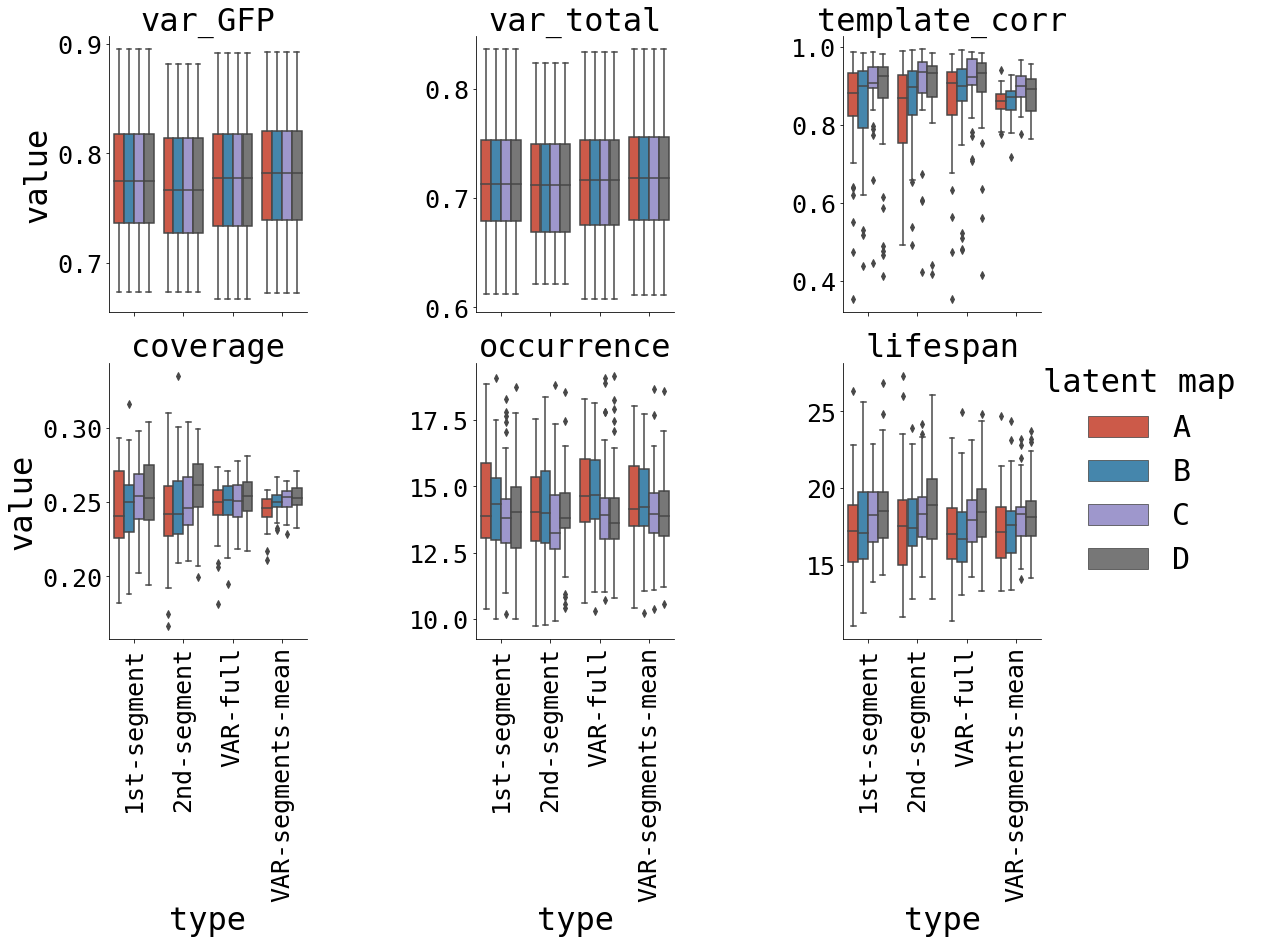

In [13]:
melt = static_stats_final.reset_index().melt(
    id_vars=["latent map", "type", "subject_id"],
    value_vars=[
        "var_GFP",
        "var_total",
        "template_corr",
        "coverage",
        "occurrence",
        "lifespan",
    ],
)
g = sns.catplot(
    data=melt,
    col="variable",
    col_wrap=3,
    hue="latent map",
    x="type",
    y="value",
    kind="box",
    sharey=False,
)
g.set_titles(col_template="{col_name}")
g.set_xticklabels(rotation=90)

In [14]:
STATS_COLS = [
    "var_GFP",
    "var_total",
    "template_corr",
    "coverage",
    "occurrence",
    "lifespan",
    "transition->A",
    "transition->B",
    "transition->C",
    "transition->D",
]

real_data_diff = (
    static_stats[static_stats["type"] == "2nd-segment"]
    .sort_values(["subject_id", "latent map"])
    .set_index(["subject_id", "latent map"])[STATS_COLS]
    - static_stats[static_stats["type"] == "1st-segment"]
    .sort_values(["subject_id", "latent map"])
    .set_index(["subject_id", "latent map"])[STATS_COLS]
)

var_full_diff = (
    static_stats[static_stats["type"] == "2nd-segment"]
    .sort_values(["subject_id", "latent map"])
    .set_index(["subject_id", "latent map"])[STATS_COLS]
    - static_stats[static_stats["type"] == "VAR-full"]
    .sort_values(["subject_id", "latent map"])
    .set_index(["subject_id", "latent map"])[STATS_COLS]
)

all_segments = sorted(
    static_stats["type"][static_stats["type"].str.match(r"VAR-\d*-segment")].unique()
)
all_segments_diffs = []
for segment in all_segments:
    df_temp = (
        static_stats[static_stats["type"] == "2nd-segment"]
        .sort_values(["subject_id", "latent map"])
        .set_index(["subject_id", "latent map"])[STATS_COLS]
        - static_stats[static_stats["type"] == segment]
        .sort_values(["subject_id", "latent map"])
        .set_index(["subject_id", "latent map"])[STATS_COLS]
    )
    df_temp["segment"] = segment
    all_segments_diffs.append(df_temp)
all_segments_diffs = pd.concat(all_segments_diffs)
var_segments_diff_mean = (
    all_segments_diffs.reset_index().groupby(["subject_id", "latent map"]).mean()
)

real_data_diff["diffs"] = "real_data"
var_full_diff["diffs"] = "VAR-full"
var_segments_diff_mean["diffs"] = "VAR-segments"
static_diffs = pd.concat([real_data_diff, var_full_diff, var_segments_diff_mean]).reset_index()

In [15]:
DVS = ["var_GFP", "var_total", "template_corr", "coverage", "occurrence", "lifespan"]

for dv in DVS:
    print(f"== {dv} ==")
    display(pg.rm_anova(data=static_diffs, dv=dv, within="diffs", subject="subject_id"))
    display(pg.pairwise_ttests(data=static_diffs, dv=dv, within="diffs", subject="subject_id", padjust="fdr_by"))

== var_GFP ==


/Users/nikola/.virtualenvs/eeg_latent/lib/python3.7/site-packages/pingouin/distribution.py:977: RuntimeWarning: divide by zero encountered in double_scalars
  W = np.product(eig) / (eig.sum() / d) ** d


,Source,ddof1,ddof2,F,p-unc,ng2,eps
0,diffs,2,98,8.645363,0.000348,0.0103,0.532249


/Users/nikola/.virtualenvs/eeg_latent/lib/python3.7/site-packages/pingouin/pairwise.py:27: UserWarning: pairwise_ttests is deprecated, use pairwise_tests instead.
  warnings.warn("pairwise_ttests is deprecated, use pairwise_tests instead.", UserWarning)


,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,hedges
0,diffs,VAR-full,VAR-segments,True,True,13.356931,49.0,two-sided,5.930552e-18,3.261804e-17,fdr_by,9.313e+14,0.204705
1,diffs,VAR-full,real_data,True,True,0.008627,49.0,two-sided,9.931517e-01,1.000000e+00,fdr_by,0.154,0.000651
2,diffs,VAR-segments,real_data,True,True,-3.102508,49.0,two-sided,3.181579e-03,8.749342e-03,fdr_by,10.185,-0.217752


== var_total ==


/Users/nikola/.virtualenvs/eeg_latent/lib/python3.7/site-packages/pingouin/distribution.py:977: RuntimeWarning: divide by zero encountered in double_scalars
  W = np.product(eig) / (eig.sum() / d) ** d


,Source,ddof1,ddof2,F,p-unc,ng2,eps
0,diffs,2,98,9.711584,0.000142,0.012892,0.515596


/Users/nikola/.virtualenvs/eeg_latent/lib/python3.7/site-packages/pingouin/pairwise.py:27: UserWarning: pairwise_ttests is deprecated, use pairwise_tests instead.
  warnings.warn("pairwise_ttests is deprecated, use pairwise_tests instead.", UserWarning)


,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,hedges
0,diffs,VAR-full,VAR-segments,True,True,16.627798,49.0,two-sided,8.737718e-22,4.805745e-21,fdr_by,4.906e+18,0.196284
1,diffs,VAR-full,real_data,True,True,-0.747564,49.0,two-sided,4.582959e-01,8.402091e-01,fdr_by,0.2,-0.059574
2,diffs,VAR-segments,real_data,True,True,-3.580670,49.0,two-sided,7.853619e-04,2.159745e-03,fdr_by,35.368,-0.268140


== template_corr ==


,Source,ddof1,ddof2,F,p-unc,ng2,eps
0,diffs,2,98,3.538444,0.032827,0.021042,0.64595


/Users/nikola/.virtualenvs/eeg_latent/lib/python3.7/site-packages/pingouin/pairwise.py:27: UserWarning: pairwise_ttests is deprecated, use pairwise_tests instead.
  warnings.warn("pairwise_ttests is deprecated, use pairwise_tests instead.", UserWarning)


,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,hedges
0,diffs,VAR-full,VAR-segments,True,True,-2.501509,49.0,two-sided,0.015756,0.086660,fdr_by,2.548,-0.221905
1,diffs,VAR-full,real_data,True,True,-2.014071,49.0,two-sided,0.049509,0.136151,fdr_by,0.985,-0.321618
2,diffs,VAR-segments,real_data,True,True,-1.036847,49.0,two-sided,0.304897,0.558978,fdr_by,0.255,-0.139398


== coverage ==


/Users/nikola/.virtualenvs/eeg_latent/lib/python3.7/site-packages/pingouin/distribution.py:977: RuntimeWarning: divide by zero encountered in double_scalars
  W = np.product(eig) / (eig.sum() / d) ** d


,Source,ddof1,ddof2,F,p-unc,ng2,eps
0,diffs,2,98,3.082169,0.050332,0.015526,0.875308


/Users/nikola/.virtualenvs/eeg_latent/lib/python3.7/site-packages/pingouin/pairwise.py:27: UserWarning: pairwise_ttests is deprecated, use pairwise_tests instead.
  warnings.warn("pairwise_ttests is deprecated, use pairwise_tests instead.", UserWarning)


,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,hedges
0,diffs,VAR-full,VAR-segments,True,True,-2.131740,49.0,two-sided,0.038068,0.139746,fdr_by,1.22,-0.236581
1,diffs,VAR-full,real_data,True,True,-2.002178,49.0,two-sided,0.050817,0.139746,fdr_by,0.964,-0.263388
2,diffs,VAR-segments,real_data,True,True,-0.512713,49.0,two-sided,0.610456,1.000000,fdr_by,0.174,-0.060945


== occurrence ==


,Source,ddof1,ddof2,F,p-unc,ng2,eps
0,diffs,2,98,11.237331,0.00004,0.031317,0.932986


/Users/nikola/.virtualenvs/eeg_latent/lib/python3.7/site-packages/pingouin/pairwise.py:27: UserWarning: pairwise_ttests is deprecated, use pairwise_tests instead.
  warnings.warn("pairwise_ttests is deprecated, use pairwise_tests instead.", UserWarning)


,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,hedges
0,diffs,VAR-full,VAR-segments,True,True,-3.012106,49.0,two-sided,0.004096,0.011265,fdr_by,8.158,-0.236567
1,diffs,VAR-full,real_data,True,True,-4.252872,49.0,two-sided,0.000095,0.000520,fdr_by,241.38,-0.408970
2,diffs,VAR-segments,real_data,True,True,-2.091505,49.0,two-sided,0.041689,0.076429,fdr_by,1.133,-0.206951


== lifespan ==


,Source,ddof1,ddof2,F,p-unc,p-GG-corr,ng2,eps,sphericity,W-spher,p-spher
0,diffs,2,98,13.410252,0.000007,0.000039,0.032515,0.807579,False,0.761732,0.001456


/Users/nikola/.virtualenvs/eeg_latent/lib/python3.7/site-packages/pingouin/pairwise.py:27: UserWarning: pairwise_ttests is deprecated, use pairwise_tests instead.
  warnings.warn("pairwise_ttests is deprecated, use pairwise_tests instead.", UserWarning)


,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,hedges
0,diffs,VAR-full,VAR-segments,True,True,3.331416,49.0,two-sided,0.001649,0.004535,fdr_by,18.223,0.199123
1,diffs,VAR-full,real_data,True,True,4.483491,49.0,two-sided,0.000044,0.000244,fdr_by,484.214,0.428574
2,diffs,VAR-segments,real_data,True,True,2.583632,49.0,two-sided,0.012810,0.023486,fdr_by,3.039,0.251209


In [16]:
dynamic_stats = pd.read_csv(
    os.path.join(RESULTS_FOLDER, "dynamic_stats.csv"), index_col=0
)
dynamic_stats[["subject_id", "type"]] = (
    dynamic_stats["subject_id"].str.split("_", expand=True).drop([1], axis=1)
)
dynamic_stats = dynamic_stats.sort_values(["subject_id", "type"])
# make mean / std from VAR segments
var_means = (
    dynamic_stats.loc[dynamic_stats["type"].str.match("VAR-\d*-segment")]
    .groupby(["subject_id"])
    .mean()
    .reset_index()
)
var_means["type"] = "VAR-segments-mean"

dynamic_stats_final = pd.concat(
    [dynamic_stats.loc[~dynamic_stats["type"].str.match("VAR-\d*-segment")], var_means],
    axis=0,
)
dynamic_stats_final = dynamic_stats_final.set_index(["subject_id", "type"])
dynamic_stats_final

mixing time   entropy  max entropy  \
subject_id type                                                    
sub-010005 1st-segment           3.912495  1.997074          2.0   
           2nd-segment           3.746140  1.995607          2.0   
           VAR-full              3.820335  1.998045          2.0   
sub-010010 1st-segment           3.596514  1.985708          2.0   
           2nd-segment           3.841792  1.993058          2.0   
...                                   ...       ...          ...   
sub-010310 VAR-segments-mean     3.401695  1.994568          2.0   
sub-010311 VAR-segments-mean     3.537773  1.991992          2.0   
sub-010315 VAR-segments-mean     3.213512  1.993431          2.0   
sub-010316 VAR-segments-mean     3.892753  1.992266          2.0   
sub-010318 VAR-segments-mean     2.993089  1.993534          2.0   

                              entropy_rate  MC entropy rate  AIF 1st peak  
subject_id type                                                            
sub-010005 1st-segment            0.998731         1.031841     60.000000  
           2nd-segment            1.008335         1.039378     60.000000  
           VAR-full               1.029065         1.050657     56.000000  
sub-010010 1st-segment            1.051934         1.091217     52.000000  
           2nd-segment            1.052984         1.089103     56.000000  
...                                    ...              ...           ...  
sub-010310 VAR-segments-mean      1.110621         1.153981     47.066667  
sub-010311 VAR-segments-mean      1.065368         1.102876     49.733333  
sub-010315 VAR-segments-mean      1.138061         1.183345     41.866667  
sub-010316 VAR-segments-mean      1.030004         1.069800     52.133333  
sub-010318 VAR-segments-mean      1.191912         1.255031     44.000000  

[200 rows x 6 columns]

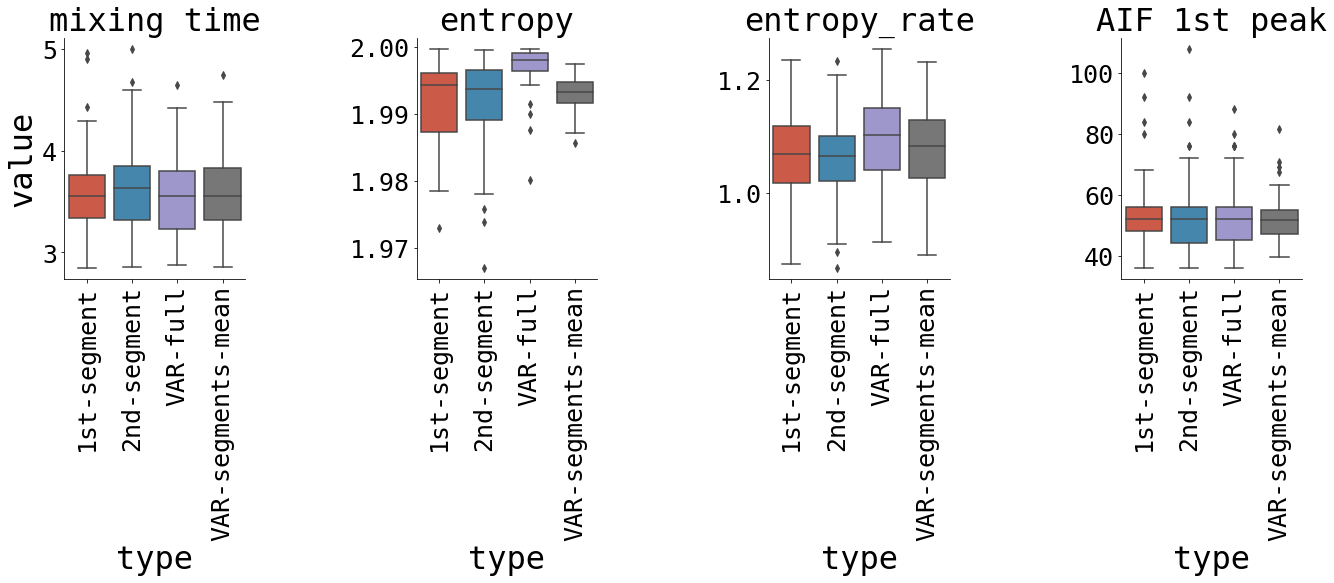

In [17]:
g = sns.catplot(
    data=dynamic_stats_final.reset_index().melt(
        id_vars=["subject_id", "type"],
        value_vars=["mixing time", "entropy", "entropy_rate", "AIF 1st peak"],
    ),
    col="variable",
    col_wrap=4,
    x="type",
    y="value",
    kind="box",
    sharey=False,
)
g.set_titles(col_template="{col_name}")
g.set_xticklabels(rotation=90)

In [18]:
dynamic_stats

,subject_id,mixing time,entropy,max entropy,entropy_rate,MC entropy rate,AIF 1st peak,type
0,sub-010005,3.912495,1.997074,2.0,0.998731,1.031841,60.0,1st-segment
0,sub-010005,3.746140,1.995607,2.0,1.008335,1.039378,60.0,2nd-segment
0,sub-010005,3.701846,1.985390,2.0,1.017639,1.051901,56.0,VAR-10-segment
0,sub-010005,4.036523,1.990426,2.0,1.023899,1.056480,56.0,VAR-11-segment
0,sub-010005,3.893565,1.988861,2.0,1.026036,1.059883,56.0,VAR-13-segment
...,...,...,...,...,...,...,...,...
0,sub-010318,3.037090,1.991654,2.0,1.193387,1.250811,44.0,VAR-6-segment
0,sub-010318,2.991528,1.996531,2.0,1.196662,1.255731,44.0,VAR-60-segment
0,sub-010318,3.059050,1.998651,2.0,1.184274,1.244996,44.0,VAR-8-segment
0,sub-010318,2.995821,1.995145,2.0,1.190261,1.241256,44.0,VAR-9-segment


In [19]:
STATS_COLS = [
    "mixing time",
    "entropy",
    "entropy_rate",
    "AIF 1st peak",
]

real_data_diff = (
    dynamic_stats[dynamic_stats["type"] == "2nd-segment"]
    .sort_values(["subject_id"])
    .set_index(["subject_id"])[STATS_COLS]
    - dynamic_stats[dynamic_stats["type"] == "1st-segment"]
    .sort_values(["subject_id"])
    .set_index(["subject_id"])[STATS_COLS]
)

var_full_diff = (
    dynamic_stats[dynamic_stats["type"] == "2nd-segment"]
    .sort_values(["subject_id"])
    .set_index(["subject_id"])[STATS_COLS]
    - dynamic_stats[dynamic_stats["type"] == "VAR-full"]
    .sort_values(["subject_id"])
    .set_index(["subject_id"])[STATS_COLS]
)

all_segments = sorted(
    dynamic_stats["type"][dynamic_stats["type"].str.match(r"VAR-\d*-segment")].unique()
)
all_segments_diffs = []
for segment in all_segments:
    df_temp = (
        dynamic_stats[dynamic_stats["type"] == "2nd-segment"]
        .sort_values(["subject_id"])
        .set_index(["subject_id"])[STATS_COLS]
        - dynamic_stats[dynamic_stats["type"] == segment]
        .sort_values(["subject_id"])
        .set_index(["subject_id"])[STATS_COLS]
    )
    df_temp["segment"] = segment
    all_segments_diffs.append(df_temp)
all_segments_diffs = pd.concat(all_segments_diffs)
var_segments_diff_mean = (
    all_segments_diffs.reset_index().groupby(["subject_id"]).mean()
)

real_data_diff["diffs"] = "real_data"
var_full_diff["diffs"] = "VAR-full"
var_segments_diff_mean["diffs"] = "VAR-segments"
dynamic_diffs = pd.concat([real_data_diff, var_full_diff, var_segments_diff_mean]).reset_index()

In [20]:
dynamic_diffs

,subject_id,mixing time,entropy,entropy_rate,AIF 1st peak,diffs
0,sub-010005,-0.166355,-0.001467,0.009603,0.000000,real_data
1,sub-010010,0.245278,0.007350,0.001050,4.000000,real_data
2,sub-010012,0.011584,0.003028,-0.001868,0.000000,real_data
3,sub-010017,0.128664,-0.000226,0.030136,-16.000000,real_data
4,sub-010027,-0.140412,-0.001474,-0.009926,-4.000000,real_data
...,...,...,...,...,...,...
145,sub-010310,0.034364,-0.000752,-0.014933,0.933333,VAR-segments
146,sub-010311,0.075582,-0.001908,-0.013773,-9.733333,VAR-segments
147,sub-010315,-0.009964,-0.011853,0.000328,2.133333,VAR-segments
148,sub-010316,-0.154440,-0.002871,-0.015478,-0.133333,VAR-segments


In [21]:
DVS = ["mixing time", "entropy", "entropy_rate", "AIF 1st peak"]

for dv in DVS:
    print(f"== {dv} ==")
    display(pg.rm_anova(data=dynamic_diffs, dv=dv, within="diffs", subject="subject_id"))
    display(pg.pairwise_ttests(data=dynamic_diffs, dv=dv, within="diffs", subject="subject_id", padjust="fdr_by"))

== mixing time ==


,Source,ddof1,ddof2,F,p-unc,p-GG-corr,ng2,eps,sphericity,W-spher,p-spher
0,diffs,2,98,3.82789,0.025079,0.041543,0.01624,0.688677,False,0.54794,5.365295e-07


/Users/nikola/.virtualenvs/eeg_latent/lib/python3.7/site-packages/pingouin/pairwise.py:27: UserWarning: pairwise_ttests is deprecated, use pairwise_tests instead.
  warnings.warn("pairwise_ttests is deprecated, use pairwise_tests instead.", UserWarning)


,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,hedges
0,diffs,VAR-full,VAR-segments,True,True,2.021904,49.0,two-sided,0.048664,0.133827,fdr_by,0.999,0.144860
1,diffs,VAR-full,real_data,True,True,2.222292,49.0,two-sided,0.030911,0.133827,fdr_by,1.448,0.297052
2,diffs,VAR-segments,real_data,True,True,1.457213,49.0,two-sided,0.151437,0.277634,fdr_by,0.414,0.170069


== entropy ==


/Users/nikola/.virtualenvs/eeg_latent/lib/python3.7/site-packages/pingouin/distribution.py:977: RuntimeWarning: divide by zero encountered in double_scalars
  W = np.product(eig) / (eig.sum() / d) ** d


,Source,ddof1,ddof2,F,p-unc,ng2,eps
0,diffs,2,98,21.366217,1.989582e-08,0.075342,0.679094


/Users/nikola/.virtualenvs/eeg_latent/lib/python3.7/site-packages/pingouin/pairwise.py:27: UserWarning: pairwise_ttests is deprecated, use pairwise_tests instead.
  warnings.warn("pairwise_ttests is deprecated, use pairwise_tests instead.", UserWarning)


,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,hedges
0,diffs,VAR-full,VAR-segments,True,True,-8.619621,49.0,two-sided,2.190569e-11,1.204813e-10,fdr_by,4.314e+08,-0.521928
1,diffs,VAR-full,real_data,True,True,-4.933850,49.0,two-sided,9.702749e-06,2.668256e-05,fdr_by,1969.095,-0.613873
2,diffs,VAR-segments,real_data,True,True,-0.919647,49.0,two-sided,3.622626e-01,6.641480e-01,fdr_by,0.229,-0.110830


== entropy_rate ==


/Users/nikola/.virtualenvs/eeg_latent/lib/python3.7/site-packages/pingouin/distribution.py:977: RuntimeWarning: divide by zero encountered in double_scalars
  W = np.product(eig) / (eig.sum() / d) ** d


,Source,ddof1,ddof2,F,p-unc,ng2,eps
0,diffs,2,98,67.606472,3.549750e-19,0.183331,0.571257


/Users/nikola/.virtualenvs/eeg_latent/lib/python3.7/site-packages/pingouin/pairwise.py:27: UserWarning: pairwise_ttests is deprecated, use pairwise_tests instead.
  warnings.warn("pairwise_ttests is deprecated, use pairwise_tests instead.", UserWarning)


,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,hedges
0,diffs,VAR-full,VAR-segments,True,True,-21.524524,49.0,two-sided,1.264479e-26,6.954635e-26,fdr_by,2.545e+23,-0.778353
1,diffs,VAR-full,real_data,True,True,-9.106425,49.0,two-sided,4.094276e-12,1.125926e-11,fdr_by,2.154e+09,-1.109701
2,diffs,VAR-segments,real_data,True,True,-2.747762,49.0,two-sided,8.374054e-03,1.535243e-02,fdr_by,4.378,-0.315802


== AIF 1st peak ==


,Source,ddof1,ddof2,F,p-unc,p-GG-corr,ng2,eps,sphericity,W-spher,p-spher
0,diffs,2,98,1.581455,0.210879,0.216088,0.005163,0.693779,False,0.55862,8.526856e-07


/Users/nikola/.virtualenvs/eeg_latent/lib/python3.7/site-packages/pingouin/pairwise.py:27: UserWarning: pairwise_ttests is deprecated, use pairwise_tests instead.
  warnings.warn("pairwise_ttests is deprecated, use pairwise_tests instead.", UserWarning)


,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,hedges
0,diffs,VAR-full,VAR-segments,True,True,-2.092583,49.0,two-sided,0.041588,0.228733,fdr_by,1.135,-0.141531
1,diffs,VAR-full,real_data,True,True,0.314239,49.0,two-sided,0.754674,1.000000,fdr_by,0.161,0.035270
2,diffs,VAR-segments,real_data,True,True,1.637229,49.0,two-sided,0.107990,0.296972,fdr_by,0.533,0.162915
